# Predicting Substance Dependence from Multi-Site Data

This notebook explores an example using data from the ENIGMA Addiction Consortium. Within this notebook we will be trying to predict between participants with any drug dependence (alcohol, cocaine, etc...), vs. healthy controls. The data for this is sources from a number of individual studies from all around the world and with different scanners etc... making this a challenging problem with its own unique considerations. Structural FreeSurfer ROIs are used. The raw data cannot be made available due to data use agreements.

The key idea explored in this notebook is a particular tricky problem introduced by case-only sites, which are subject's data from site's with only case's. This introduces a confound where you cannot easily tell if the classifier is learning to predict site or the dependence status of interest.

Featured in this notebook as well are some helpful
code snippets for converting from BPt versions earlier than BPt 2.0 to valid BPt 2.0+ code.

In [1]:
import pandas as pd
import BPt as bp
import numpy as np
import matplotlib.pyplot as plt

from warnings import simplefilter
simplefilter("ignore", category=FutureWarning)

### Loading / Preparing Data

As a general tip it can be useful to wrap something like a series of steps that load multiple DataFrames and merge them into a function. That said, it is often useful when first writing the function to try it taking advantage of the interactive-ness of the jupyter-notebook.

In [2]:
def load_base_df():
    '''Loads and merges a DataFrame from multiple raw files'''
    
    na_vals = [' ', '  ', 'nan', 'NaN']
    
    # Load first part of data
    d1 = pd.read_excel('/home/sage/Downloads/e1.xlsx', na_values=na_vals)
    d2 = pd.read_excel('/home/sage/Downloads/e2.xlsx', na_values=na_vals)
    df = pd.concat([d1, d2])

    df['Subject'] = df['Subject'].astype('str')
    df.rename({'Subject': 'subject'}, axis=1, inplace=True)
    df.set_index('subject', inplace=True)

    # Load second part
    df2 = pd.read_excel('/home/sage/Downloads/e3.xlsx', na_values=na_vals)
    df2['Subject ID'] = df2['Subject ID'].astype('str')
    df2.rename({'Subject ID': 'subject'}, axis=1, inplace=True)
    df2.set_index('subject', inplace=True)

    # Merge
    data = df2.merge(df, on='subject', how='outer')
    
    # Rename age and sex
    data = data.rename({'Sex_y': 'Sex', 'Age_y': 'Age'}, axis=1)
    
    # Remove subject name to obsficate
    data.index = list(range(len(data.index)))
    
    return data

In [3]:
df = load_base_df()
df.shape

(3525, 224)

In [4]:
# Cast to dataset
data = bp.Dataset(df)
data.verbose = 1

# Drop non relevant columns
data.drop_cols_by_nan(threshold=.5, inplace=True)
data.drop_cols(scope='Dependent', inclusions='any drug', inplace=True)
data.drop_cols(exclusions=['Half', '30 days', 'Site ',
                           'Sex_', 'Age_', 'Primary Drug', 'ICV.'], inplace=True)

# Set binary vars as categorical
data.auto_detect_categorical(inplace=True)
data.to_binary(scope='category', inplace=True)
print('to binary cols:', data.get_cols('category'))

# Set target and drop any NaNs
data.set_role('Dependent any drug', 'target', inplace=True)
data.drop_nan_subjects('target', inplace=True)

# Save this set of vars under scope covars
data = data.add_scope(['ICV', 'Sex', 'Age', 'Education', 'Handedness'], 'covars')
print('scope covars = ', data.get_cols('covars'))

# Set site as non input
data = data.set_role('Site', 'non input')
data = data.ordinalize(scope='non input')

# Drop subjects with too many NaN's and big outliers
data.drop_subjects_by_nan(threshold=.5, scope='all', inplace=True)
data.filter_outliers_by_std(n_std=10, scope='float', inplace=True)

Setting NaN threshold to: 1762.5
Dropped 20 Columns
Dropped 3 Columns
Dropped 36 Columns
Num. categorical variables in dataset: 3
to binary cols: ['Dependent any drug', 'Handedness', 'Sex']
Dropped 479 Rows
scope covars =  ['Age', 'Education', 'Handedness', 'ICV', 'Sex']
Setting NaN threshold to: 82.5
Dropped 38 Rows
Dropped 5 Rows


**Legacy Equivilent pre BPt 2.0 loading code**

```
ML = BPt_ML('Enigma_Alc',
             log_dr = None,
             n_jobs = 8)
             
ML.Set_Default_Load_Params(subject_id = 'subject',
                           na_values = [' ', '  ', 'nan', 'NaN'],
                           drop_na = .5)
                           
ML.Load_Data(df=df,
             drop_keys = ['Unnamed:', 'Site', 'Half', 'PI', 'Dependent',
                          'Surface Area', 'Thickness', 'ICV', 'Subcortical',
                          'Sex', 'Age', 'Primary Drug', 'Education', 'Handedness'],
             inclusion_keys=None,
             unique_val_warn=None,
             clear_existing=True)

ML.Load_Targets(df=df,
                col_name = 'Dependent any drug',
                data_type = 'b')

ML.Load_Covars(df=df,
               col_name = ['ICV', 'Sex', 'Age'],
               drop_na = False,
               data_type = ['f', 'b', 'f'])

ML.Load_Covars(df = df,
               col_name = ['Education', 'Handedness'],
               data_type = ['f', 'b'],
               drop_na = False,
               filter_outlier_std = 10)

ML.Load_Strat(df=df,
              col_name=['Sex', 'Site'],
              binary_col=[True, False]
              )

ML.Prepare_All_Data()
```

Let's take a look at what we prepared. We can see that visually the Dataset is grouped by role.

Let's plot some variables of interest

Dependent any drug: 3003 rows


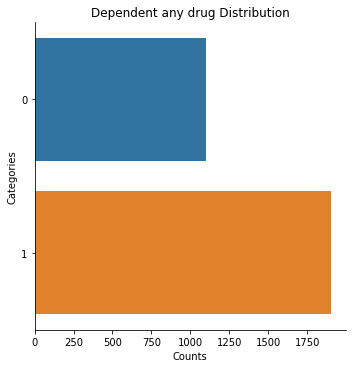

In [5]:
data.plot('target')

Site: 3003 rows


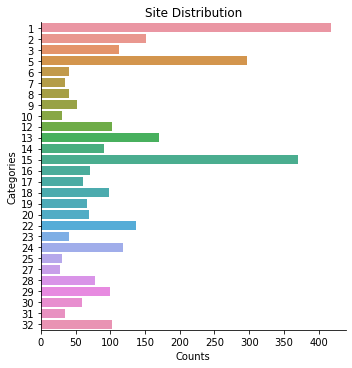

In [6]:
data.plot('Site')

Site: 3003 rows
Dependent any drug: 3003 rows
Plotting 3003 overlap valid subjects.


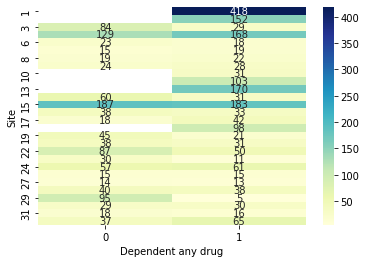

In [7]:
data.plot_bivar('Site', 'Dependent any drug')

That bi-variate plot is a little hard to read... we can make it bigger though easy enough. Let's say we also wanted to save it (we need to add show=False)

Site: 3003 rows
Dependent any drug: 3003 rows
Plotting 3003 overlap valid subjects.


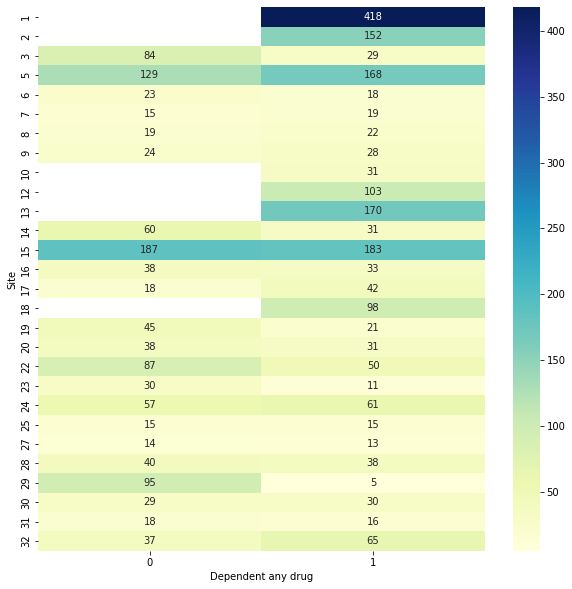

In [8]:
plt.figure(figsize=(10, 10))
data.plot_bivar('Site', 'Dependent any drug', show=False)
plt.savefig('site_by_drug.png', dpi=200)

Okay next, we are going to define a custom validation strategy to use, which is essentially going to preserve subjects within the same train and test fold based on site.


**Legacy Code**
```
from BPt import CV
group_site = CV(groups='Site')
```

In [9]:
group_site = bp.CVStrategy(groups='Site')
group_site

CVStrategy(groups='Site')

We then can use this CV strategy as an argument when defining the train test split.

**Legacy Code**
```
ML.Train_Test_Split(test_size =.2, cv=group_site)
```

In [10]:
data = data.set_test_split(size=.2, cv_strategy=group_site, random_state=5)

Performing test split on: 3003 subjects.
random_state: 5
Test split size: 0.2

Performed train/test split
Train size: 2379
Test size:  624


Dependent any drug: 2379 rows


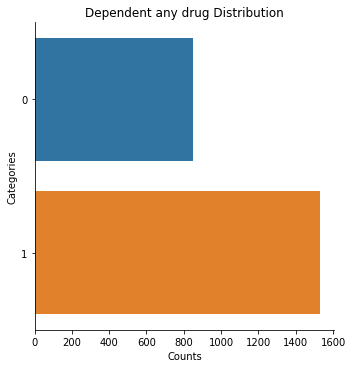

Dependent any drug: 624 rows


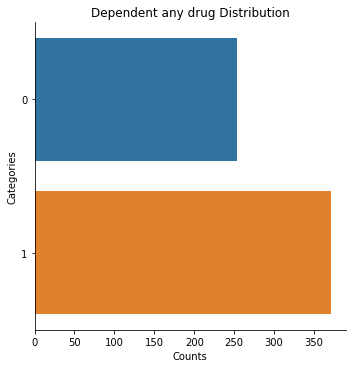

In [11]:
data.plot('target', subjects='train')
data.plot('target', subjects='test')

### Running ML

Next, we are going to evaluate some different machine learning models on the problem we have defined. Notably not much has changed here with respect to the old version, except some cosmetic changes like Problem_Spec to ProblemSpec. Also we have a new `evaluate` function instead of calling Evaluate via the ML object (`ML.Evaluate`).

In [12]:
# This just holds some commonly used values
ps = bp.ProblemSpec(subjects='train',
                    scorer=['matthews', 'roc_auc', 'balanced_accuracy'],
                    n_jobs=16)
ps

ProblemSpec(n_jobs=16, scorer=['matthews', 'roc_auc', 'balanced_accuracy'],
            subjects='train')

In [13]:
# Define a ModelPipeline to use with imputation, scaling and an elastic net
pipe = bp.ModelPipeline(imputers=[bp.Imputer(obj='mean', scope='float'),
                                  bp.Imputer(obj='median', scope='category')],
                        scalers=bp.Scaler('standard'), 
                        model=bp.Model('elastic', params=1),
                        param_search=bp.ParamSearch(
                            search_type='DiscreteOnePlusOne', n_iter=64))
pipe.print_all()

ModelPipeline
-------------
imputers=\
[Imputer(obj='mean', scope='float'),
 Imputer(obj='median', scope='category')]

scalers=\
Scaler(obj='standard')

model=\
Model(obj='elastic', params=1)

param_search=\
ParamSearch(cv=CV(cv_strategy=CVStrategy()), n_iter=64,
            search_type='DiscreteOnePlusOne')



### 3-fold CV random splits

Let's start by evaluating this model is a fairly naive way, just 3 folds of CV.

In [14]:
results = bp.evaluate(pipeline=pipe, dataset=data, mute_warnings=True,
                      problem_spec=ps, cv=bp.CV(splits=3))
results

Predicting target = Dependent any drug
Using problem_type = binary
Using scope = all (defining a total of 163 features).
Evaluating 2379 total data points.


Folds:   0%|          | 0/3 [00:00<?, ?it/s]


Training Set: (1586, 163)
Validation Set: (793, 163)
Fit fold in 15.1 seconds.
matthews: 0.4370
roc_auc: 0.8163
balanced_accuracy: 0.7249

Training Set: (1586, 163)
Validation Set: (793, 163)
Fit fold in 11.3 seconds.
matthews: 0.4449
roc_auc: 0.8169
balanced_accuracy: 0.7302

Training Set: (1586, 163)
Validation Set: (793, 163)
Fit fold in 11.3 seconds.
matthews: 0.3919
roc_auc: 0.7859
balanced_accuracy: 0.7021



BPtEvaluator
------------
matthews: 0.4246 ± 0.0233
roc_auc: 0.8064 ± 0.0145
balanced_accuracy: 0.7191 ± 0.0122

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Avaliable Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: Dependent any drug
problem_type: binary
scope: all
subjects: train
random_state: 1
n_jobs: 16


Notably this is likely going to give us overly optimistic results. Let's look at just the Site's drawn from the first evaluation fold to get a feel for why.

Site: 1586 rows
Dependent any drug: 1586 rows
Plotting 1586 overlap valid subjects.


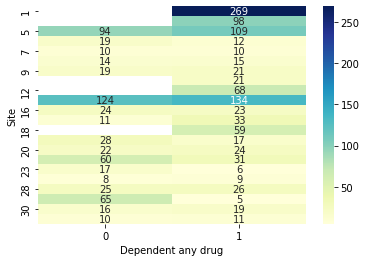

Site: 793 rows
Dependent any drug: 793 rows
Plotting 793 overlap valid subjects.


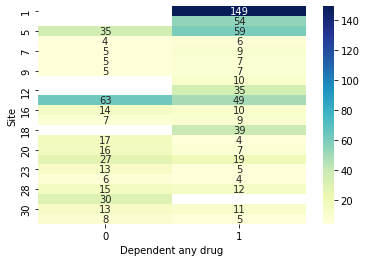

In [15]:
data.plot_bivar('Site', 'Dependent any drug', subjects=results.train_subjects[0])
data.plot_bivar('Site', 'Dependent any drug', subjects=results.val_subjects[0])

### Preserving Groups by Site

We can see that for example the 149 subjects from site 1 in the validation set had 269 subjects also from site 1 to potentially memorize site effects from! The confound is a site with only cases. One way we can account for this is through something we've already hinted at, using the group site cv from earlier. We can create a new CV object with this attribute.

In [16]:
site_cv = bp.CV(splits=3, cv_strategy=group_site)
site_cv

CV(cv_strategy=CVStrategy(groups='Site'))

In [17]:
results = bp.evaluate(pipeline=pipe, dataset=data, mute_warnings=True,
                      problem_spec=ps, cv=site_cv)
results

Predicting target = Dependent any drug
Using problem_type = binary
Using scope = all (defining a total of 163 features).
Evaluating 2379 total data points.


Folds:   0%|          | 0/3 [00:00<?, ?it/s]


Training Set: (1471, 163)
Validation Set: (908, 163)
Fit fold in 10.2 seconds.
matthews: 0.4206
roc_auc: 0.7941
balanced_accuracy: 0.7315

Training Set: (1413, 163)
Validation Set: (966, 163)
Fit fold in 10.2 seconds.
matthews: 0.2592
roc_auc: 0.7009
balanced_accuracy: 0.6301

Training Set: (1874, 163)
Validation Set: (505, 163)
Fit fold in 12.3 seconds.
matthews: 0.2049
roc_auc: 0.6837
balanced_accuracy: 0.5930



BPtEvaluator
------------
matthews: 0.2949 ± 0.0916
roc_auc: 0.7262 ± 0.0485
balanced_accuracy: 0.6515 ± 0.0585

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Avaliable Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: Dependent any drug
problem_type: binary
scope: all
subjects: train
random_state: 1
n_jobs: 16


We can now make the same plots as before, confirming now that the sites are different.

Site: 1471 rows
Dependent any drug: 1471 rows
Plotting 1471 overlap valid subjects.


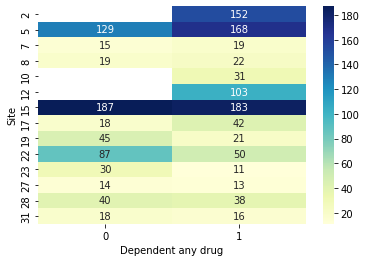

Site: 908 rows
Dependent any drug: 908 rows
Plotting 908 overlap valid subjects.


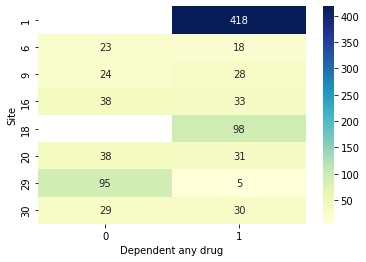

In [18]:
data.plot_bivar('Site', 'Dependent any drug', subjects=results.train_subjects[0])
data.plot_bivar('Site', 'Dependent any drug', subjects=results.val_subjects[0])

Another piece we might want to look at in this case is the weighted_mean_scores. That is, each of the splits has train and test sets of slightly different sizes, so how does the metric change if we weight it by the number of validation subjects in that fold

In [19]:
results.weighted_mean_scores

{'matthews': 0.3092616733691502,
 'roc_auc': 0.7328240262274902,
 'balanced_accuracy': 0.660923246869063}

In [20]:
results = bp.evaluate(pipeline=pipe, dataset=data, mute_warnings=True,
                      problem_spec=ps, cv=3)
results

Predicting target = Dependent any drug
Using problem_type = binary
Using scope = all (defining a total of 163 features).
Evaluating 2379 total data points.


Folds:   0%|          | 0/3 [00:00<?, ?it/s]


Training Set: (1586, 163)
Validation Set: (793, 163)
Fit fold in 10.4 seconds.
matthews: 0.4926
roc_auc: 0.8217
balanced_accuracy: 0.7540

Training Set: (1586, 163)
Validation Set: (793, 163)
Fit fold in 10.2 seconds.
matthews: 0.3594
roc_auc: 0.7746
balanced_accuracy: 0.6853

Training Set: (1586, 163)
Validation Set: (793, 163)
Fit fold in 10.6 seconds.
matthews: 0.4196
roc_auc: 0.8055
balanced_accuracy: 0.7169



BPtEvaluator
------------
matthews: 0.4239 ± 0.0545
roc_auc: 0.8006 ± 0.0195
balanced_accuracy: 0.7187 ± 0.0281

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Avaliable Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: Dependent any drug
problem_type: binary
scope: all
subjects: train
random_state: 1
n_jobs: 16


### Other options?

What other options do we have to handle site with CV besides just the group splitting?

1. Explicit leave-out-site CV: Where every train set is composed of all sites but one, and the validation set is the left out site.

2. Use the train-only parameter in CV.

3. Only evaluate subjects from sites with both cases and controls.

Let's try option 1 first.

### Leave-out-site CV

In [21]:
# All we need to do for leave-out-site is specify that splits = Site
leave_out_site_cv = bp.CV(splits='Site')

# This will actually raise an error
try:
    results = bp.evaluate(pipeline=pipe, dataset=data, mute_warnings=True,
                          problem_spec=ps, cv=leave_out_site_cv)
except Exception as exc:
    print(exc)

Predicting target = Dependent any drug
Using problem_type = binary
Using scope = all (defining a total of 163 features).
Evaluating 2379 total data points.


Folds:   0%|          | 0/22 [00:00<?, ?it/s]


Training Set: (1961, 163)
Validation Set: (418, 163)
Fit fold in 11.9 seconds.
matthews: 0.0000
Only one class present in y_true. ROC AUC score is not defined in that case.


Uh oh looks like this option actually failed. What happened? Well basically since we have sites with only one class, we are trying to compute metrics that require two classes. Let's try again this time just using scorers that can work in the case of only one class.

In [22]:
results = bp.evaluate(pipeline=pipe, dataset=data, scorer='accuracy', mute_warnings=True,
                      problem_spec=ps, cv=leave_out_site_cv)

results.mean_scores, results.std_scores, results.weighted_mean_scores

Predicting target = Dependent any drug
Using problem_type = binary
Using scope = all (defining a total of 163 features).
Evaluating 2379 total data points.


Folds:   0%|          | 0/22 [00:00<?, ?it/s]


Training Set: (1961, 163)
Validation Set: (418, 163)
Fit fold in 13.2 seconds.
accuracy: 0.8852

Training Set: (2227, 163)
Validation Set: (152, 163)
Fit fold in 14.2 seconds.
accuracy: 0.9737

Training Set: (2082, 163)
Validation Set: (297, 163)
Fit fold in 13.0 seconds.
accuracy: 0.6667

Training Set: (2338, 163)
Validation Set: (41, 163)
Fit fold in 14.5 seconds.
accuracy: 0.5366

Training Set: (2345, 163)
Validation Set: (34, 163)
Fit fold in 20.9 seconds.
accuracy: 0.5588

Training Set: (2338, 163)
Validation Set: (41, 163)
Fit fold in 21.7 seconds.
accuracy: 0.5366

Training Set: (2327, 163)
Validation Set: (52, 163)
Fit fold in 14.1 seconds.
accuracy: 0.7115

Training Set: (2348, 163)
Validation Set: (31, 163)
Fit fold in 14.7 seconds.
accuracy: 0.9677

Training Set: (2276, 163)
Validation Set: (103, 163)
Fit fold in 14.3 seconds.
accuracy: 0.9612

Training Set: (2009, 163)
Validation Set: (370, 163)
Fit fold in 13.3 seconds.
accuracy: 0.5243

Training Set: (2308, 163)
Validati

({'accuracy': 0.6171531879494896},
 {'accuracy': 0.19921938998418204},
 {'accuracy': 0.662463219840269})

The problem here is accuracy is likely a pretty bad metric, especially for the sites which have both cases and controls, but a skewed distribution. In general using the group preserving by Site is likely a better option.

### Train-only subjects

One optional way of handling these subjects from sites with only cases or only controls is to just never evaluate them. To instead always treat them as train subjects. We can notably then either use random splits or group preserving by CV.

In [23]:
def check_imbalanced(df):
    as_int = df['Dependent any drug'].astype('int')
    return np.sum(as_int) == len(as_int)

# Apply function to check if each site has all the same target variable
is_imbalanced = data.groupby('Site').apply(check_imbalanced)

# Note these are internal values, not the original ones
imbalanced_sites = np.flatnonzero(is_imbalanced)

# We can specify just these subjects using the ValueSubset wrapper
imbalanced_subjs = bp.ValueSubset('Site', values=imbalanced_sites, decode_values=False)

In [24]:
# Now define our new version of the group site cv
site_cv_tr_only = bp.CV(splits=3, cv_strategy=group_site,
                        train_only_subjects=imbalanced_subjs)

# And evaluate
results = bp.evaluate(pipeline=pipe, dataset=data, mute_warnings=True,
                      problem_spec=ps, cv=site_cv_tr_only)
results

Predicting target = Dependent any drug
Using problem_type = binary
Using scope = all (defining a total of 163 features).
Evaluating 2379 total data points.


Folds:   0%|          | 0/3 [00:00<?, ?it/s]


Training Set: (1523, 163)
Validation Set: (856, 163)
Fit fold in 11.1 seconds.
matthews: 0.1104
roc_auc: 0.5882
balanced_accuracy: 0.5552

Training Set: (1966, 163)
Validation Set: (413, 163)
Fit fold in 11.5 seconds.
matthews: -0.0383
roc_auc: 0.4847
balanced_accuracy: 0.4801

Training Set: (2071, 163)
Validation Set: (308, 163)
Fit fold in 13.2 seconds.
matthews: 0.0192
roc_auc: 0.5318
balanced_accuracy: 0.5095



BPtEvaluator
------------
matthews: 0.0304 ± 0.0612
roc_auc: 0.5349 ± 0.0423
balanced_accuracy: 0.5149 ± 0.0309

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Avaliable Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: Dependent any drug
problem_type: binary
scope: all
subjects: train
random_state: 1
n_jobs: 16


The take-away here is maybe a little bleak. Essentially it is saying that some of the high scores we got earlier might have been in large part due to scores from the imbalanced sites.

In [25]:
# And we can also run a version with just random splits
tr_only_cv = bp.CV(splits=3, train_only_subjects=imbalanced_subjs)

# And evaluate
results = bp.evaluate(pipeline=pipe, dataset=data, mute_warnings=True,
                      problem_spec=ps, cv=tr_only_cv)
results

Predicting target = Dependent any drug
Using problem_type = binary
Using scope = all (defining a total of 163 features).
Evaluating 2379 total data points.


Folds:   0%|          | 0/3 [00:00<?, ?it/s]


Training Set: (1853, 163)
Validation Set: (526, 163)
Fit fold in 12.7 seconds.
matthews: 0.2438
roc_auc: 0.6503
balanced_accuracy: 0.6165

Training Set: (1853, 163)
Validation Set: (526, 163)
Fit fold in 12.4 seconds.
matthews: 0.2744
roc_auc: 0.6635
balanced_accuracy: 0.6244

Training Set: (1854, 163)
Validation Set: (525, 163)
Fit fold in 14.8 seconds.
matthews: 0.2293
roc_auc: 0.6671
balanced_accuracy: 0.6117



BPtEvaluator
------------
matthews: 0.2492 ± 0.0188
roc_auc: 0.6603 ± 0.0072
balanced_accuracy: 0.6175 ± 0.0052

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Avaliable Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: Dependent any drug
problem_type: binary
scope: all
subjects: train
random_state: 1
n_jobs: 16


While this version with random splits does better, we are still notably ignoring the distribution of case to control in the sites with both cases and controls. Based on the group preserving results what it seems like is going on is that when subjects from the same site are split across validation folds, the classifier might be able to just memorize Site instead of the effect of interest. Lets use Site 29 as an example.

Let's look at just fold 1 first.

Site: 70 rows
Dependent any drug: 70 rows
Plotting 70 overlap valid subjects.


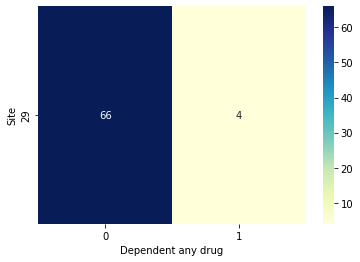

Site: 30 rows
Dependent any drug: 30 rows
Plotting 30 overlap valid subjects.


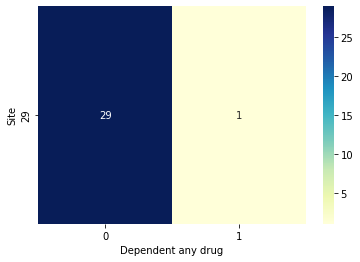

,predict,predict_proba_0,predict_proba_1,decision_function,y_true
3458,0.0,0.833460,0.166540,-1.610353,0.0
3459,0.0,0.923985,0.076015,-2.497768,0.0
3462,0.0,0.982916,0.017084,-4.052401,0.0
3470,0.0,0.965650,0.034350,-3.336200,0.0
3478,0.0,0.975289,0.024711,-3.675504,0.0
3479,0.0,0.927494,0.072506,-2.548814,0.0
3482,0.0,0.962700,0.037300,-3.250741,0.0
3484,0.0,0.716777,0.283223,-0.928531,0.0
3485,0.0,0.939462,0.060538,-2.742031,0.0
3486,0.0,0.963918,0.036082,-3.285205,0.0


In [26]:
# The train and val subjects from fold 0
tr_subjs = results.train_subjects[0]
val_subjs = results.val_subjects[0]

# An object specifying just site 29's subjects
site29 = bp.ValueSubset('Site', 29, decode_values=True)

# Get the intersection w/ intersection obj
site_29_tr = bp.Intersection([tr_subjs, site29])
site_29_val = bp.Intersection([val_subjs, site29])

# Plot
data.plot_bivar('Site', 'Dependent any drug', subjects=bp.Intersection([tr_subjs, site29]))
data.plot_bivar('Site', 'Dependent any drug', subjects=bp.Intersection([val_subjs, site29]))

# Grab just the subjects as actual index
val_subjs = data.get_subjects(site_29_val)

# Get a dataframe with the predictions made for just fold0
preds_df_fold0 = results.get_preds_dfs()[0]

# Let's see predictions for just these validation subjects
preds_df_fold0.loc[val_subjs]

We can see that it has learned to just predict 0 for every subject, which because of the imbalance is right most of the time, but really doesn't tell us if it has learned to predict site or substance dependence.

### Drop imbalanced subjects
The last option was just don't use the imbalanced subjects at all. We will do this by indexing only the balanced sites

In [27]:
# Note the ~ before the previously defined is_imbalanced
balanced_sites = np.flatnonzero(~is_imbalanced)

# We can specify just these subjects using the ValueSubset wrapper
balanced_subjs = bp.ValueSubset('Site', values=balanced_sites, decode_values=False)

In [28]:
# Evaluate with site preserving cv from earlier but now using just the balanced train subjects
train_just_balanced = bp.Intersection(['train', balanced_subjs])

results = bp.evaluate(pipeline=pipe, dataset=data, mute_warnings=True,
                      subjects=train_just_balanced,
                      problem_spec=ps, cv=site_cv)
results

Predicting target = Dependent any drug
Using problem_type = binary
Using scope = all (defining a total of 163 features).
Evaluating 1577 total data points.


Folds:   0%|          | 0/3 [00:00<?, ?it/s]


Training Set: (721, 163)
Validation Set: (856, 163)
Fit fold in 9.4 seconds.
matthews: 0.2823
roc_auc: 0.6872
balanced_accuracy: 0.6371

Training Set: (1164, 163)
Validation Set: (413, 163)
Fit fold in 12.0 seconds.
matthews: 0.3120
roc_auc: 0.7122
balanced_accuracy: 0.6628

Training Set: (1269, 163)
Validation Set: (308, 163)
Fit fold in 11.6 seconds.
matthews: 0.1018
roc_auc: 0.5471
balanced_accuracy: 0.5415



BPtEvaluator
------------
matthews: 0.2320 ± 0.0929
roc_auc: 0.6488 ± 0.0727
balanced_accuracy: 0.6138 ± 0.0522

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Avaliable Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: Dependent any drug
problem_type: binary
scope: all
subjects: Intersection(['train', ValueSubset(name=Site, values=[ 2  3  4  5  6  7 11 12 13 14 16 17 18 19 20 21 22 23 24 25 26 27], decode_values=False)])
random_state: 1
n_jobs: 16


This actually seems to show that the imbalanced site confound with doesn't just corrupt cross validated results, but also actively impedes the model learning the real relationship. That we are better off just not using subjects with from sites with only cases. Yikes. 

Likewise, we can do the random split strategy again too.

In [29]:
results = bp.evaluate(pipeline=pipe, dataset=data, mute_warnings=True,
                      subjects=train_just_balanced,
                      problem_spec=ps, cv=bp.CV(splits=3))
results

Predicting target = Dependent any drug
Using problem_type = binary
Using scope = all (defining a total of 163 features).
Evaluating 1577 total data points.


Folds:   0%|          | 0/3 [00:00<?, ?it/s]


Training Set: (1051, 163)
Validation Set: (526, 163)
Fit fold in 8.8 seconds.
matthews: 0.2440
roc_auc: 0.6838
balanced_accuracy: 0.6214

Training Set: (1051, 163)
Validation Set: (526, 163)
Fit fold in 9.0 seconds.
matthews: 0.3516
roc_auc: 0.7424
balanced_accuracy: 0.6642

Training Set: (1052, 163)
Validation Set: (525, 163)
Fit fold in 8.5 seconds.
matthews: 0.3159
roc_auc: 0.7137
balanced_accuracy: 0.6586



BPtEvaluator
------------
matthews: 0.3038 ± 0.0447
roc_auc: 0.7133 ± 0.0239
balanced_accuracy: 0.6481 ± 0.0190

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Avaliable Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: Dependent any drug
problem_type: binary
scope: all
subjects: Intersection(['train', ValueSubset(name=Site, values=[ 2  3  4  5  6  7 11 12 13 14 16 17 18 19 20 21 22 23 24 25 26 27], decode_values=False)])
random_state: 1
n_jobs: 16


Also, we could run it with a leave-out-site CV. Now we can use the normal metrics.

In [30]:
results = bp.evaluate(pipeline=pipe, dataset=data, mute_warnings=True,
                      subjects=train_just_balanced,
                      problem_spec=ps, cv=leave_out_site_cv)
results

Predicting target = Dependent any drug
Using problem_type = binary
Using scope = all (defining a total of 163 features).
Evaluating 1577 total data points.


Folds:   0%|          | 0/17 [00:00<?, ?it/s]


Training Set: (1280, 163)
Validation Set: (297, 163)
Fit fold in 9.7 seconds.
matthews: 0.3240
roc_auc: 0.7394
balanced_accuracy: 0.6631

Training Set: (1536, 163)
Validation Set: (41, 163)
Fit fold in 10.8 seconds.
matthews: 0.0404
roc_auc: 0.5386
balanced_accuracy: 0.5121

Training Set: (1543, 163)
Validation Set: (34, 163)
Fit fold in 10.4 seconds.
matthews: -0.0344
roc_auc: 0.4912
balanced_accuracy: 0.4877

Training Set: (1536, 163)
Validation Set: (41, 163)
Fit fold in 10.7 seconds.
matthews: -0.0202
roc_auc: 0.5789
balanced_accuracy: 0.4916

Training Set: (1525, 163)
Validation Set: (52, 163)
Fit fold in 10.0 seconds.
matthews: 0.3536
roc_auc: 0.6905
balanced_accuracy: 0.6280

Training Set: (1207, 163)
Validation Set: (370, 163)
Fit fold in 10.0 seconds.
matthews: 0.2365
roc_auc: 0.6651
balanced_accuracy: 0.6057

Training Set: (1506, 163)
Validation Set: (71, 163)
Fit fold in 10.6 seconds.
matthews: 0.0000
roc_auc: 0.5175
balanced_accuracy: 0.5000

Training Set: (1517, 163)
Vali

BPtEvaluator
------------
matthews: 0.1463 ± 0.1774
roc_auc: 0.6074 ± 0.1213
balanced_accuracy: 0.5650 ± 0.0803

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Avaliable Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: Dependent any drug
problem_type: binary
scope: all
subjects: Intersection(['train', ValueSubset(name=Site, values=[ 2  3  4  5  6  7 11 12 13 14 16 17 18 19 20 21 22 23 24 25 26 27], decode_values=False)])
random_state: 1
n_jobs: 16


### Results Summary

To summarize, of all of the above different iterations. Only the results from the versions where subjects from case-only sites are treated as train-only or dropped and evaluated group-preserving by site are likely un-biased! The leave-out-site CV results should be okay too, but let's skip those for now.

Train Only Scores:
mean_scores = {'matthews': 0.024294039432900597, 'roc_auc': 0.5292721521624003, 'balanced_accuracy': 0.5116503104881627}

Dropped Scores:
mean_scores = {'matthews': 0.23079311975258734, 'roc_auc': 0.6494071534373412, 'balanced_accuracy': 0.6141868842892168}

By these interm results we can with some confidence conclude dropping subjects is the way to go, unless we want to dig deeper...

### Disentangle Target and Site?

Can information on dependance from case-only sites be some how disentangled from site?

This actually leads to a follow up a question. Namely is there any way to extract usable information from case-only site subjects? This question I actually investigated more deeply in https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.25248 The idea of train-only subjects is actually from this paper, though it still has some important differences then the way we formulated it. 

The key piece in the paper which we haven't tried to do yet is centered around the problem of the classifier learning site related information instead of dependence related information in the train-only setup. We essentially need a way of forcing the classifier to learn this. The way proposed in the paper proposes that maybe we can by restricting the features provided to the classifier, give it only features related to dependence and not those related to site. In order to do this, we need to add a feature selection step.

There are different ways to compose the problem, but we will specify the feature selection step as a seperate layer of nesting, importantly one that is evaluated according to the same site_cv_tr_only that we will be evaluating with. Remember the goal here is to select features which help us learn to predict useful information from case only sites, i.e., with feature only related to Dependence and not site!

In [31]:
# Same imputer and scaler
imputers = [bp.Imputer(obj='mean', scope='float'),
            bp.Imputer(obj='median', scope='category')]
scaler = bp.Scaler('standard')

# This object will be used to set features as an array of binary hyper-parameters
feat_selector = bp.FeatSelector('selector', params=1)

# This param search is responsible for optimizing the selected features from feat_selector
param_search = bp.ParamSearch('RandomSearch',
                              n_iter=16,
                              cv=site_cv_tr_only)

# We create a nested elastic net model to optimize - no particular CV should be okay
random_search = bp.ParamSearch('RandomSearch', n_iter=16)
elastic_search = bp.Model('elastic', params=1,
                          param_search=random_search)

# Put it all together in a pipeline
fs_pipe = bp.Pipeline(imputers + [scaler, feat_selector, elastic_search],
                      param_search=param_search)

Note: This may take a while to evaluate as we now have two levels of parameters to optimize, e.g., for each choice
of features, we need to train a nested elastic net.

In [32]:
results = bp.evaluate(pipeline=fs_pipe, dataset=data, mute_warnings=True,
                      problem_spec=ps, cv=site_cv_tr_only)
results

Predicting target = Dependent any drug
Using problem_type = binary
Using scope = all (defining a total of 163 features).
Evaluating 2379 total data points.


Folds:   0%|          | 0/3 [00:00<?, ?it/s]


Training Set: (1523, 163)
Validation Set: (856, 163)
Fit fold in 65.5 seconds.
matthews: 0.0537
roc_auc: 0.5267
balanced_accuracy: 0.5268

Training Set: (1966, 163)
Validation Set: (413, 163)
Fit fold in 70.2 seconds.
matthews: -0.0719
roc_auc: 0.4253
balanced_accuracy: 0.4634

Training Set: (2071, 163)
Validation Set: (308, 163)
Fit fold in 84.5 seconds.
matthews: -0.0519
roc_auc: 0.4921
balanced_accuracy: 0.4740



BPtEvaluator
------------
matthews: -0.0234 ± 0.0551
roc_auc: 0.4814 ± 0.0421
balanced_accuracy: 0.4881 ± 0.0277

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'cv']

Avaliable Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'get_preds_dfs', 'subset_by', 'permutation_importance']

Evaluated With:
target: Dependent any drug
problem_type: binary
scope: all
subjects: train
random_state: 1
n_jobs: 16


Unfortunetly this doesn't seem to work. Notably we still arn't quite following the method from the paper, which performs a meta-analysis on the results from the feature search to find overlapping subsets of features. As of the time of writing this example, a simmilar strategy has not been able to be easily integrated into BPt.

The above method still has a few problems, one being severe overfitting. Namely, because a number of subjects are reserved in train-only roles, the same small number of subjects are being used over and over in cross-validation. 

We can confirm this intutiton by comparing the best score achieved internally for each set of features w/ how they score in the outer cross validation.

In [33]:
-results.estimators[0].best_score_, results.scores['matthews'][0]

(0.050966232842908764, 0.053718391221483516)

In [34]:
-results.estimators[1].best_score_, results.scores['matthews'][1]

(0.12743219380090678, -0.07188694484494394)

In [35]:
-results.estimators[2].best_score_, results.scores['matthews'][2]

(0.09538113246734702, -0.051895463921527066)

These values are quite different to say the least. Part of the problem again is that such a small amount of data is being used to determine generalization. What if instead of a the 3-fold group preserving train only feature selection CV, we instead used a leave-out-site scheme on site with train only? I doubt it will help, but let's see...

In [36]:
leave_out_site_tr_only_cv = bp.CV(splits='Site',
                                  train_only_subjects=imbalanced_subjs)

fs_pipe.param_search = bp.ParamSearch(
    'RandomSearch', n_iter=16,
    cv=leave_out_site_tr_only_cv)

results = bp.evaluate(pipeline=fs_pipe, dataset=data, mute_warnings=True,
                      problem_spec=ps, cv=site_cv_tr_only)
results

Predicting target = Dependent any drug
Using problem_type = binary
Using scope = all (defining a total of 163 features).
Evaluating 2379 total data points.


Folds:   0%|          | 0/3 [00:00<?, ?it/s]


Training Set: (1523, 163)
Validation Set: (856, 163)
Fit fold in 236.9 seconds.
matthews: 0.0702
roc_auc: 0.5447
balanced_accuracy: 0.5348

Training Set: (1966, 163)
Validation Set: (413, 163)
Fit fold in 257.9 seconds.
matthews: -0.0719
roc_auc: 0.4253
balanced_accuracy: 0.4634

Training Set: (2071, 163)
Validation Set: (308, 163)
Fit fold in 315.6 seconds.
matthews: 0.1325
roc_auc: 0.5586
balanced_accuracy: 0.5665



BPtEvaluator
------------
matthews: 0.0436 ± 0.0855
roc_auc: 0.5095 ± 0.0598
balanced_accuracy: 0.5216 ± 0.0431

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'cv']

Avaliable Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'get_preds_dfs', 'subset_by', 'permutation_importance']

Evaluated With:
target: Dependent any drug
problem_type: binary
scope: all
subjects: train
random_state: 1
n_jobs: 16


This does a little better. But only slightly. What if we also used this leave-out site strategy for the outer loop? This would be to address the issue that the outer CV has the same problem as the inner, where the validation set is overly specific and small in some folds.

In [ ]:
results = bp.evaluate(pipeline=fs_pipe,
                      dataset=data,
                      problem_spec=ps,
                      mute_warnings=True,
                      cv=leave_out_site_tr_only_cv,
                      eval_verbose=1)
results

Predicting target = Dependent any drug
Using problem_type = binary
Using scope = all (defining a total of 163 features).
Evaluating 2379 total data points.


Folds:   0%|          | 0/17 [00:00<?, ?it/s]


Training Set: (2082, 163)
Validation Set: (297, 163)
Fit fold in 416.7 seconds.
matthews: 0.3413
roc_auc: 0.6939
balanced_accuracy: 0.6669

Training Set: (2338, 163)
Validation Set: (41, 163)


Seeing the results for each site seperately with the verbose option really makes some of the problem clear, namely that a number of small sites don't seem to generalize well. This is simmilar to what we saw in the case of using leave-out-site with case-only subjects dropped, where we had a huge std in roc auc between folds.

Another potential problem with doing leave-out-site is that the way the underlying data was collected, different sites will have subjects with dependence to different substances. This can certainly cause issues, as say our classifier only learns to classify alcohol dependence (the strongest signal), then it will do poorly on sites for other substances. Which is good in one way, that it lets us know the classifier is not generalizing, but it doesn't solve the generalization problem.

Anyways, that will end this example for now. Leaving the problem of how to best exploit information from case-only sites as an open question (though if interested, a more faithful reproduction of the method presented in https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.25248 might prove to be fruitful. Specifically, in the end only using a few, maybe 3-4, features, which is notably quite different then what we are trying above, i.e., trying just 16 random sets of features).